## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.260530      565.10046    -4.184752      -4.714701   
1            2     -1.260530      565.10046    -4.184752      -4.714701   
2            3     -1.260530      565.10046    -4.184752      -4.714701   
3            4     -1.260530      565.10046    -4.184752      -4.714701   
4            5     -1.260530      565.10046    -4.184752      -4.714701   
...        ...           ...            ...          ...            ...   
1752345     46     -3.080809      529.16738   -15.814628     -20.288304   
1752346     47     -3.080809      529.16738   -15.814628     -20.288304   
1752347     48     -3.080809      529.16738   -15.814628     -20.288304   
1752348     49     -3.080809      529.16738   -15.814628     -20.288304   
1752349     50     -3.080809      529.16738   -15.814628     -20.288304   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day',  
                 'buoyancy', 'diffusivity', 'temp_initial00', 
                'temp_heat01', 'temp_diff02', 'temp_total05',
                'ice', 'snow', 'snowice']
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/direct_model_train_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.009199689
RMSE of after m0 0.0030391584
RMSE of after m0 0.0055053346
RMSE of after m0 0.007865198
RMSE of after m0 0.006726759
RMSE of after m0 0.0041659586
RMSE of after m0 0.004309878
RMSE of after m0 0.0035498831
RMSE of after m0 0.0038695289
RMSE of after m0 0.003942465
RMSE of after m0 0.003382914
RMSE of after m0 0.0035376279
RMSE of after m0 0.004231626
RMSE of after m0 0.0044513303
RMSE of after m0 0.0051547647
RMSE of after m0 0.003491697
RMSE of after m0 0.0041147373
RMSE of after m0 0.004457897
RMSE of after m0 0.004322682
RMSE of after m0 0.004387649
RMSE of after m0 0.0027989058
RMSE of after m0 0.0043078405
RMSE of after m0 0.004503181
RMSE of after m0 0.004378617
RMSE of after m0 0.0035139138
RMSE of after m0 0.0034377999
RMSE of after m0 0.003682676
RMSE of after m0 0.004305784
RMSE of after m0 0.006228497
RMSE of after m0 0.0035291775
RMSE of after m0 0.004039893
RMSE of after m0 0.004877866
RMSE of after m0 0.0048986156
RMSE of after m0 0.003761225

RMSE of after m0 0.035057485
RMSE of after m0 0.036567748
RMSE of after m0 0.03110529
RMSE of after m0 0.03281932
RMSE of after m0 0.035712454
RMSE of after m0 0.036312155
RMSE of after m0 0.032529157
RMSE of after m0 0.03030208
RMSE of after m0 0.030221837
RMSE of after m0 0.027381307
RMSE of after m0 0.026863618
RMSE of after m0 0.026189052
RMSE of after m0 0.027110199
RMSE of after m0 0.028453426
RMSE of after m0 0.029369503
RMSE of after m0 0.02776329
RMSE of after m0 0.028837036
RMSE of after m0 0.031108532
RMSE of after m0 0.028684666
RMSE of after m0 0.021680169
RMSE of after m0 0.02171523
RMSE of after m0 0.02132827
RMSE of after m0 0.023596035
RMSE of after m0 0.026212675
RMSE of after m0 0.023559762
RMSE of after m0 0.020976966
RMSE of after m0 0.023017546
RMSE of after m0 0.026553174
RMSE of after m0 0.020659436
RMSE of after m0 0.016370252
RMSE of after m0 0.01268624
RMSE of after m0 0.01646074
RMSE of after m0 0.013625246
RMSE of after m0 0.007890005
RMSE of after m0 0.008

RMSE of after m0 0.0043454547
RMSE of after m0 0.0044215024
RMSE of after m0 0.00446272
RMSE of after m0 0.003580913
RMSE of after m0 0.003216524
RMSE of after m0 0.0052646315
RMSE of after m0 0.0058116126
RMSE of after m0 0.0056642815
RMSE of after m0 0.018103074
RMSE of after m0 0.016886568
RMSE of after m0 0.010022273
RMSE of after m0 0.014632894
RMSE of after m0 0.0036967609
RMSE of after m0 0.006228853
RMSE of after m0 0.009532579
RMSE of after m0 0.011889388
RMSE of after m0 0.013889557
RMSE of after m0 0.011501241
RMSE of after m0 0.014108412
RMSE of after m0 0.010369654
RMSE of after m0 0.013946597
RMSE of after m0 0.0066847024
RMSE of after m0 0.0086626895
RMSE of after m0 0.012050983
RMSE of after m0 0.011247063
RMSE of after m0 0.013217723
RMSE of after m0 0.013207209
RMSE of after m0 0.010934821
RMSE of after m0 0.012120984
RMSE of after m0 0.013671925
RMSE of after m0 0.0135349855
RMSE of after m0 0.017253412
RMSE of after m0 0.018064162
RMSE of after m0 0.008622557
RMSE o

RMSE of after m0 0.002570914
RMSE of after m0 0.0036506713
RMSE of after m0 0.002417835
RMSE of after m0 0.0022472388
RMSE of after m0 0.0028264946
RMSE of after m0 0.0045974697
RMSE of after m0 0.005141213
RMSE of after m0 0.0034401268
RMSE of after m0 0.0026873152
RMSE of after m0 0.0046234424
RMSE of after m0 0.0046855942
RMSE of after m0 0.0043805228
RMSE of after m0 0.005791233
RMSE of after m0 0.0035038204
RMSE of after m0 0.004572921
RMSE of after m0 0.0055282135
RMSE of after m0 0.0028568325
RMSE of after m0 0.002114503
RMSE of after m0 0.0038010455
RMSE of after m0 0.0052091805
RMSE of after m0 0.0042271917
RMSE of after m0 0.004669621
RMSE of after m0 0.0043578707
RMSE of after m0 0.0042130738
RMSE of after m0 0.003786865
RMSE of after m0 0.004669963
RMSE of after m0 0.0038296697
RMSE of after m0 0.004524361
RMSE of after m0 0.004423388
RMSE of after m0 0.0040802495
RMSE of after m0 0.0042873807
RMSE of after m0 0.00442563
RMSE of after m0 0.004036835
RMSE of after m0 0.00433

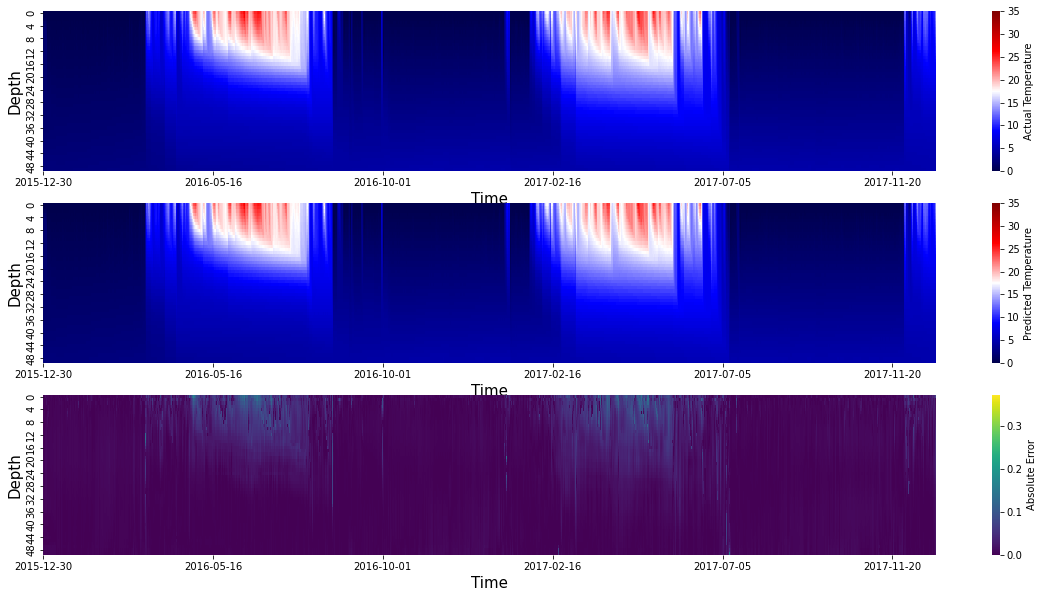

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

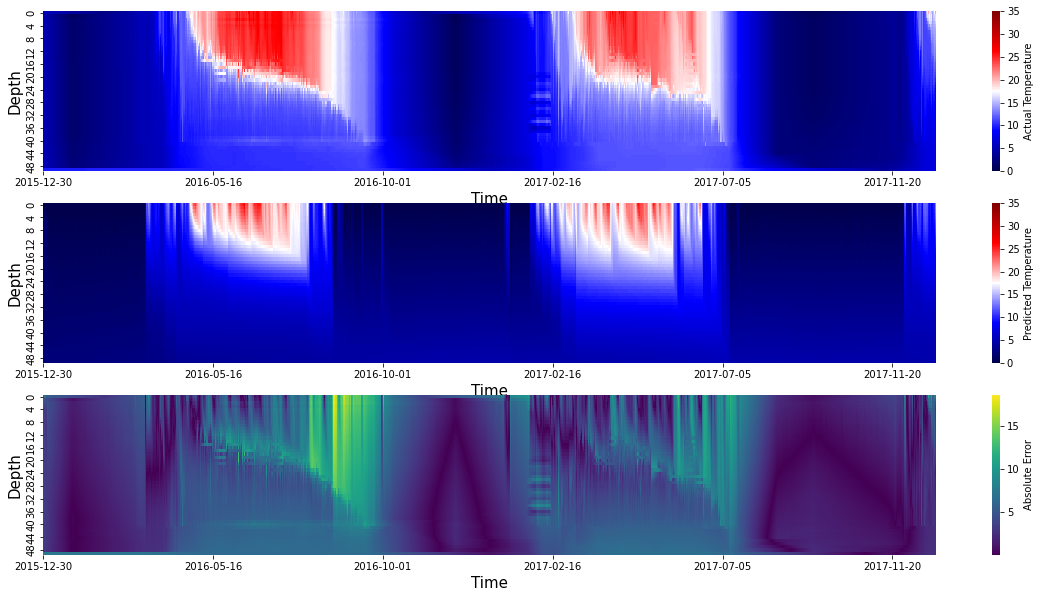

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.020854943
RMSE of after m0 0.013819559
RMSE of after m0 0.013698419
RMSE of after m0 0.014989767
RMSE of after m0 0.015246622
RMSE of after m0 0.019174267
RMSE of after m0 0.020450784
RMSE of after m0 0.019236548
RMSE of after m0 0.019078825
RMSE of after m0 0.018746167
RMSE of after m0 0.017870368
RMSE of after m0 0.02013647
RMSE of after m0 0.023826893
RMSE of after m0 0.052781295
RMSE of after m0 0.035033055
RMSE of after m0 0.040470872
RMSE of after m0 0.039250992
RMSE of after m0 0.03519919
RMSE of after m0 0.030474432
RMSE of after m0 0.032390743
RMSE of after m0 0.034958504
RMSE of after m0 0.035988014
RMSE of after m0 0.035116907
RMSE of after m0 0.031050388
RMSE of after m0 0.032373026
RMSE of after m0 0.030219045
RMSE of after m0 0.03121533
RMSE of after m0 0.024910104
RMSE of after m0 0.024311963
RMSE of after m0 0.023130938
RMSE of after m0 0.026075568
RMSE of after m0 0.025429405
RMSE of after m0 0.025179861
RMSE of after m0 0.024736311
RMSE of after m0 

RMSE of after m0 0.0058677313
RMSE of after m0 0.0038355268
RMSE of after m0 0.004387185
RMSE of after m0 0.005097759
RMSE of after m0 0.0057792757
RMSE of after m0 0.0056441254
RMSE of after m0 0.006284119
RMSE of after m0 0.003540537
RMSE of after m0 0.0035599233
RMSE of after m0 0.0047297
RMSE of after m0 0.0048822677
RMSE of after m0 0.0042177644
RMSE of after m0 0.0035971326
RMSE of after m0 0.0039620125
RMSE of after m0 0.0047879643
RMSE of after m0 0.0043965317
RMSE of after m0 0.0058345767
RMSE of after m0 0.0049784025
RMSE of after m0 0.005541388
RMSE of after m0 0.005935152
RMSE of after m0 0.005339986
RMSE of after m0 0.0044949907
RMSE of after m0 0.005465982
RMSE of after m0 0.004487788
RMSE of after m0 0.0046312404
RMSE of after m0 0.0053885174
RMSE of after m0 0.005157599
RMSE of after m0 0.0047548744
RMSE of after m0 0.0059442883
RMSE of after m0 0.00492523
RMSE of after m0 0.0058102766
RMSE of after m0 0.0046260087
RMSE of after m0 0.004153528
RMSE of after m0 0.0061070

RMSE of after m0 0.020322762
RMSE of after m0 0.020526763
RMSE of after m0 0.021824585
RMSE of after m0 0.0190972
RMSE of after m0 0.019801797
RMSE of after m0 0.0209191
RMSE of after m0 0.019016948
RMSE of after m0 0.019771224
RMSE of after m0 0.020871801
RMSE of after m0 0.021242566
RMSE of after m0 0.022975266
RMSE of after m0 0.01871426
RMSE of after m0 0.019004595
RMSE of after m0 0.018163906
RMSE of after m0 0.018833023
RMSE of after m0 0.015532262
RMSE of after m0 0.022345139
RMSE of after m0 0.013470688
RMSE of after m0 0.016912531
RMSE of after m0 0.014614173
RMSE of after m0 0.010577596
RMSE of after m0 0.0092089465
RMSE of after m0 0.011656951
RMSE of after m0 0.011871502
RMSE of after m0 0.011450162
RMSE of after m0 0.019140659
RMSE of after m0 0.017248597
RMSE of after m0 0.011231457
RMSE of after m0 0.015472803
RMSE of after m0 0.020240393
RMSE of after m0 0.04147529
RMSE of after m0 0.016634813
RMSE of after m0 0.024657784
RMSE of after m0 0.03206629
RMSE of after m0 0.0

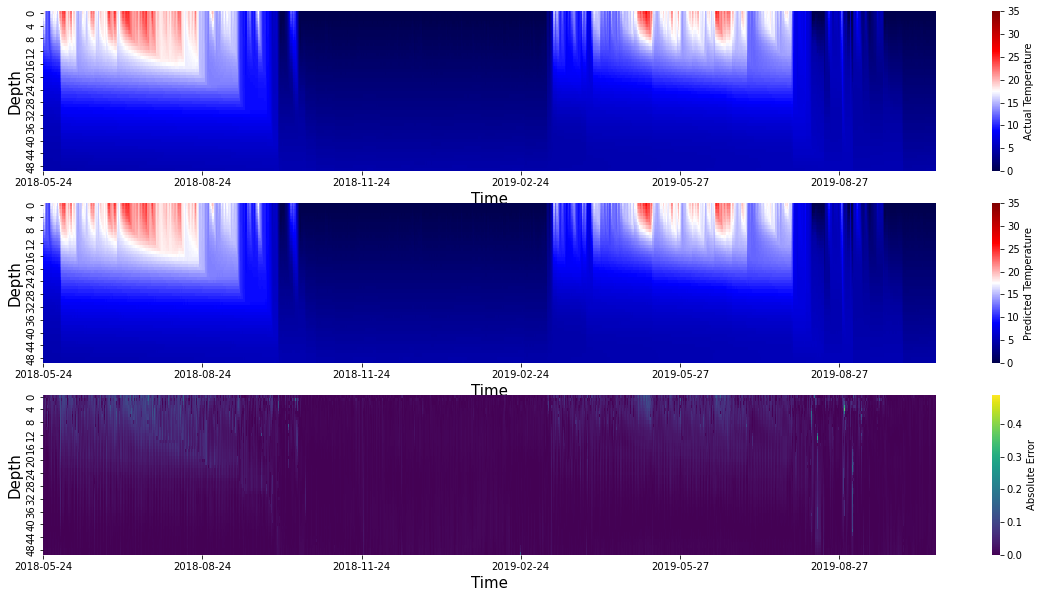

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

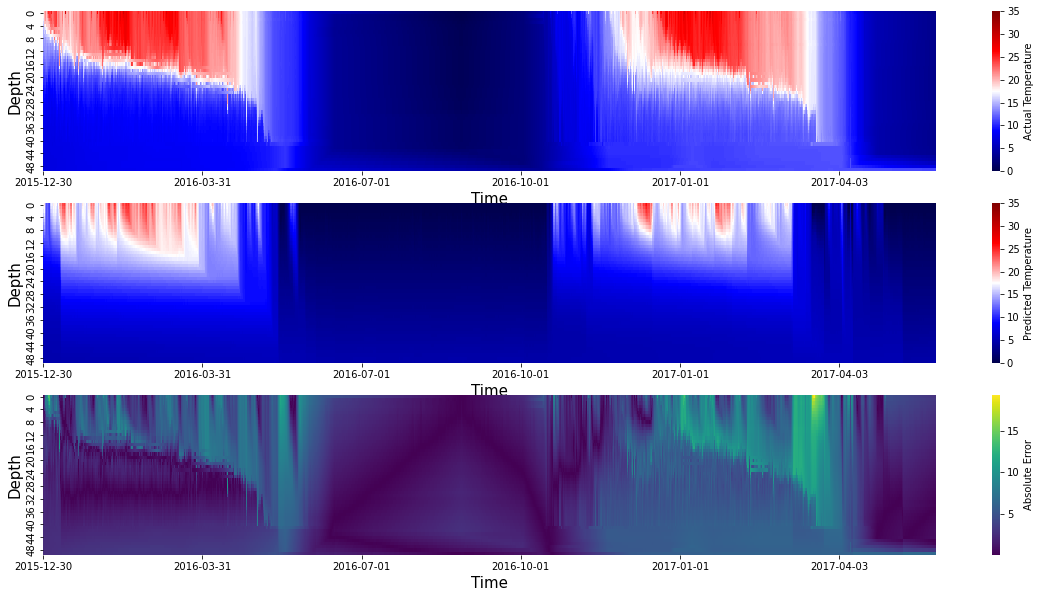

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.019015189840326855, Train L2 Error: 0.002531945523932282
Test RMSE: 0.02110645765014702, Train L2 Error: 0.0024682221563640276


## Mixing Model

## Convection Model

## Ice Model

# Finetuning

In [25]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(direct_model.parameters()) 
optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [26]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [27]:
#freeze_model(heating_model)

unfreeze_model(direct_model)


# Finetuning on Observed Temperature

In [28]:
direct_model.train()


n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out0 = torch.tensor(train_mean[m0_output_column_ix[0]]).float().to(device)
std_out0 = torch.tensor(train_std[m0_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input

train_loss = []
LOSS_m0 = []


for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0

    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out0)/std_out0
        
        loss_m0 = criterion(m0_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m0
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()

    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)

    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:16<4:32:09, 16.35s/it]

Epoch : 0, Train_loss: 0.7388670526457306, Loss m0: 0.7388670526457306


  5%|▌         | 51/1000 [11:23<3:08:03, 11.89s/it]

Epoch : 50, Train_loss: 0.12722049854313353, Loss m0: 0.12722049854313353


 10%|█         | 101/1000 [22:06<3:10:38, 12.72s/it]

Epoch : 100, Train_loss: 0.10382571623296771, Loss m0: 0.10382571623296771


 15%|█▌        | 151/1000 [32:46<2:59:15, 12.67s/it]

Epoch : 150, Train_loss: 0.09398335757503329, Loss m0: 0.09398335757503329


 20%|██        | 201/1000 [43:40<2:56:13, 13.23s/it]

Epoch : 200, Train_loss: 0.08722011039069828, Loss m0: 0.08722011039069828


 25%|██▌       | 251/1000 [55:30<3:15:48, 15.69s/it]

Epoch : 250, Train_loss: 0.08186959536850608, Loss m0: 0.08186959536850608


 30%|███       | 301/1000 [1:08:42<3:25:21, 17.63s/it]

Epoch : 300, Train_loss: 0.07676043046639255, Loss m0: 0.07676043046639255


 35%|███▌      | 351/1000 [1:22:28<2:55:03, 16.18s/it]

Epoch : 350, Train_loss: 0.0710196356179977, Loss m0: 0.0710196356179977


 40%|████      | 401/1000 [1:36:14<2:42:31, 16.28s/it]

Epoch : 400, Train_loss: 0.06527318169985642, Loss m0: 0.06527318169985642


 45%|████▌     | 451/1000 [1:49:53<2:30:10, 16.41s/it]

Epoch : 450, Train_loss: 0.05969885492004842, Loss m0: 0.05969885492004842


 50%|█████     | 501/1000 [2:03:00<2:23:23, 17.24s/it]

Epoch : 500, Train_loss: 0.05429453437654576, Loss m0: 0.05429453437654576


 55%|█████▌    | 551/1000 [2:16:15<1:47:04, 14.31s/it]

Epoch : 550, Train_loss: 0.04841594172832193, Loss m0: 0.04841594172832193


 60%|██████    | 601/1000 [2:28:11<1:37:02, 14.59s/it]

Epoch : 600, Train_loss: 0.0414775302475398, Loss m0: 0.0414775302475398


 65%|██████▌   | 651/1000 [2:40:59<1:26:32, 14.88s/it]

Epoch : 650, Train_loss: 0.037405913879113545, Loss m0: 0.037405913879113545


 70%|███████   | 701/1000 [2:53:29<1:12:22, 14.52s/it]

Epoch : 700, Train_loss: 0.03541721312275835, Loss m0: 0.03541721312275835


 75%|███████▌  | 751/1000 [3:05:25<54:57, 13.24s/it]  

Epoch : 750, Train_loss: 0.03401606971510428, Loss m0: 0.03401606971510428


 80%|████████  | 801/1000 [3:16:12<43:08, 13.01s/it]

Epoch : 800, Train_loss: 0.03291130187827607, Loss m0: 0.03291130187827607


 85%|████████▌ | 851/1000 [3:27:08<25:41, 10.35s/it]

Epoch : 850, Train_loss: 0.032003395441251616, Loss m0: 0.032003395441251616


 90%|█████████ | 901/1000 [3:35:22<15:48,  9.58s/it]

Epoch : 900, Train_loss: 0.031234829786757914, Loss m0: 0.031234829786757914


 95%|█████████▌| 951/1000 [3:43:12<07:36,  9.31s/it]

Epoch : 950, Train_loss: 0.030578005802640584, Loss m0: 0.030578005802640584


100%|██████████| 1000/1000 [3:50:51<00:00, 13.85s/it]


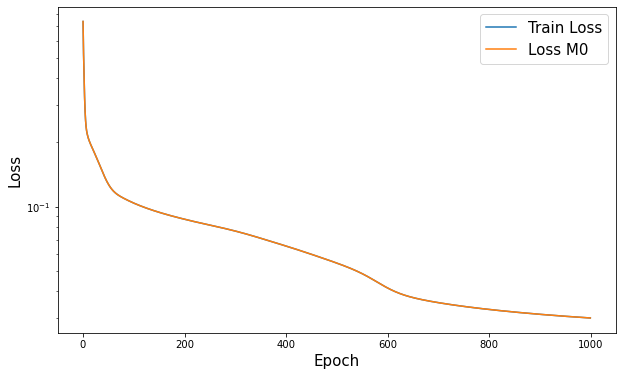

In [36]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")

plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [30]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 3.4414964
RMSE of after m0 3.4671888
RMSE of after m0 3.435894
RMSE of after m0 3.2288456
RMSE of after m0 3.318722
RMSE of after m0 3.2970889
RMSE of after m0 3.2144506
RMSE of after m0 3.1201637
RMSE of after m0 2.9123263
RMSE of after m0 2.964698
RMSE of after m0 2.8892145
RMSE of after m0 2.8684967
RMSE of after m0 2.787886
RMSE of after m0 2.743535
RMSE of after m0 2.5896137
RMSE of after m0 2.5481274
RMSE of after m0 2.6445184
RMSE of after m0 2.593684
RMSE of after m0 2.4293659
RMSE of after m0 2.3991807
RMSE of after m0 2.5137548
RMSE of after m0 2.374147
RMSE of after m0 2.1483083
RMSE of after m0 2.1505947
RMSE of after m0 1.9154634
RMSE of after m0 1.86034
RMSE of after m0 1.7839663
RMSE of after m0 1.7964838
RMSE of after m0 1.8202448
RMSE of after m0 1.7703526
RMSE of after m0 1.7203993
RMSE of after m0 1.7701371
RMSE of after m0 1.540853
RMSE of after m0 1.3773106
RMSE of after m0 1.466168
RMSE of after m0 1.5568658
RMSE of after m0 1.5019668
RMSE of afte

RMSE of after m0 5.8295836
RMSE of after m0 5.8109117
RMSE of after m0 6.2649074
RMSE of after m0 7.159403
RMSE of after m0 8.49492
RMSE of after m0 8.849792
RMSE of after m0 8.966025
RMSE of after m0 7.9154387
RMSE of after m0 7.4182215
RMSE of after m0 7.4133234
RMSE of after m0 7.687184
RMSE of after m0 7.7729015
RMSE of after m0 7.8720603
RMSE of after m0 7.77748
RMSE of after m0 8.036434
RMSE of after m0 8.364783
RMSE of after m0 8.491187
RMSE of after m0 8.290863
RMSE of after m0 8.023701
RMSE of after m0 7.3578196
RMSE of after m0 6.8900747
RMSE of after m0 6.430789
RMSE of after m0 6.5058103
RMSE of after m0 6.7169347
RMSE of after m0 6.854488
RMSE of after m0 7.381572
RMSE of after m0 7.6403637
RMSE of after m0 7.2696977
RMSE of after m0 7.258863
RMSE of after m0 7.411575
RMSE of after m0 8.07254
RMSE of after m0 11.857363
RMSE of after m0 12.820484
RMSE of after m0 12.519207
RMSE of after m0 12.819682
RMSE of after m0 12.792744
RMSE of after m0 11.166533
RMSE of after m0 10.1

RMSE of after m0 3.2003043
RMSE of after m0 3.0109797
RMSE of after m0 3.012013
RMSE of after m0 2.9445767
RMSE of after m0 2.882647
RMSE of after m0 2.593898
RMSE of after m0 2.6082783
RMSE of after m0 2.6954558
RMSE of after m0 2.6174953
RMSE of after m0 2.608315
RMSE of after m0 2.6317375
RMSE of after m0 2.6477473
RMSE of after m0 2.6792145
RMSE of after m0 2.719149
RMSE of after m0 2.7945936
RMSE of after m0 2.8249483
RMSE of after m0 2.9417205
RMSE of after m0 2.9905946
RMSE of after m0 2.992866
RMSE of after m0 3.0980833
RMSE of after m0 3.0956187
RMSE of after m0 3.0616264
RMSE of after m0 3.116545
RMSE of after m0 3.1580472
RMSE of after m0 3.1332698
RMSE of after m0 3.0724027
RMSE of after m0 3.095779
RMSE of after m0 3.17056
RMSE of after m0 3.2240622
RMSE of after m0 3.2542593
RMSE of after m0 3.3309197
RMSE of after m0 3.3822105
RMSE of after m0 3.4290588
RMSE of after m0 3.5982013
RMSE of after m0 3.8332846
RMSE of after m0 3.7394748
RMSE of after m0 3.5905912
RMSE of aft

RMSE of after m0 1.1294632
RMSE of after m0 1.1054558
RMSE of after m0 1.1191531
RMSE of after m0 1.2425925
RMSE of after m0 1.1092861
RMSE of after m0 1.1714152
RMSE of after m0 1.2358142
RMSE of after m0 1.2218353
RMSE of after m0 1.2064898
RMSE of after m0 1.1788031
RMSE of after m0 1.1763785
RMSE of after m0 1.1849372
RMSE of after m0 1.2726344
RMSE of after m0 1.1563439
RMSE of after m0 1.188369
RMSE of after m0 1.159257
RMSE of after m0 1.2677505
RMSE of after m0 1.2794616
RMSE of after m0 1.2947165
RMSE of after m0 1.2878798
RMSE of after m0 1.32063
RMSE of after m0 1.3302741
RMSE of after m0 1.3097767
RMSE of after m0 1.2782401
RMSE of after m0 1.439696
RMSE of after m0 1.413867
RMSE of after m0 1.4015431
RMSE of after m0 1.3426204
RMSE of after m0 1.393969
RMSE of after m0 1.4005532
RMSE of after m0 1.3926418
RMSE of after m0 1.440021
RMSE of after m0 1.3500592
RMSE of after m0 1.4629214
RMSE of after m0 1.4232256
RMSE of after m0 1.4224639
RMSE of after m0 1.4165874
RMSE of a

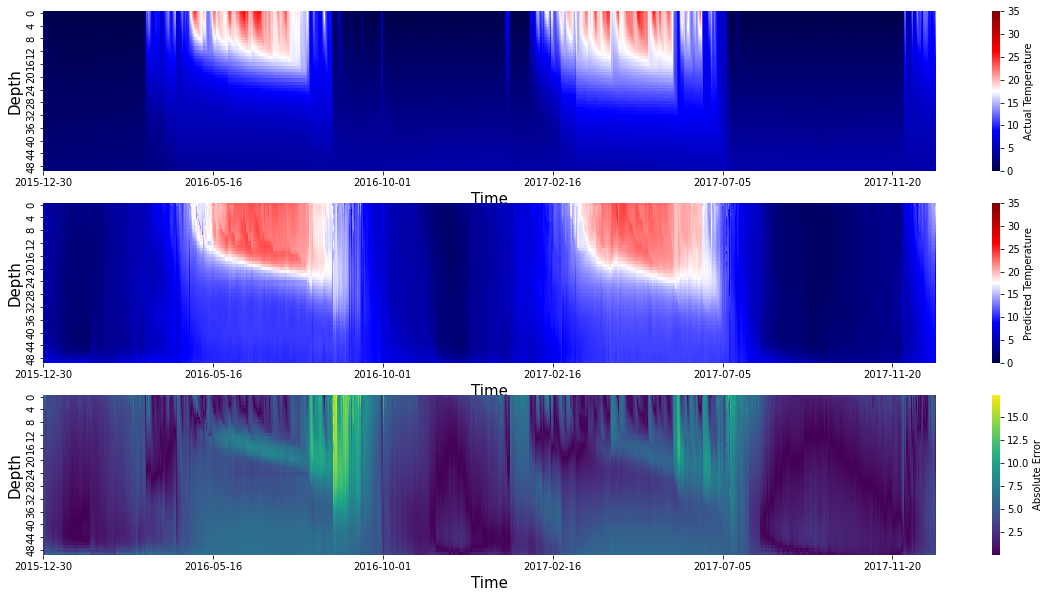

In [31]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

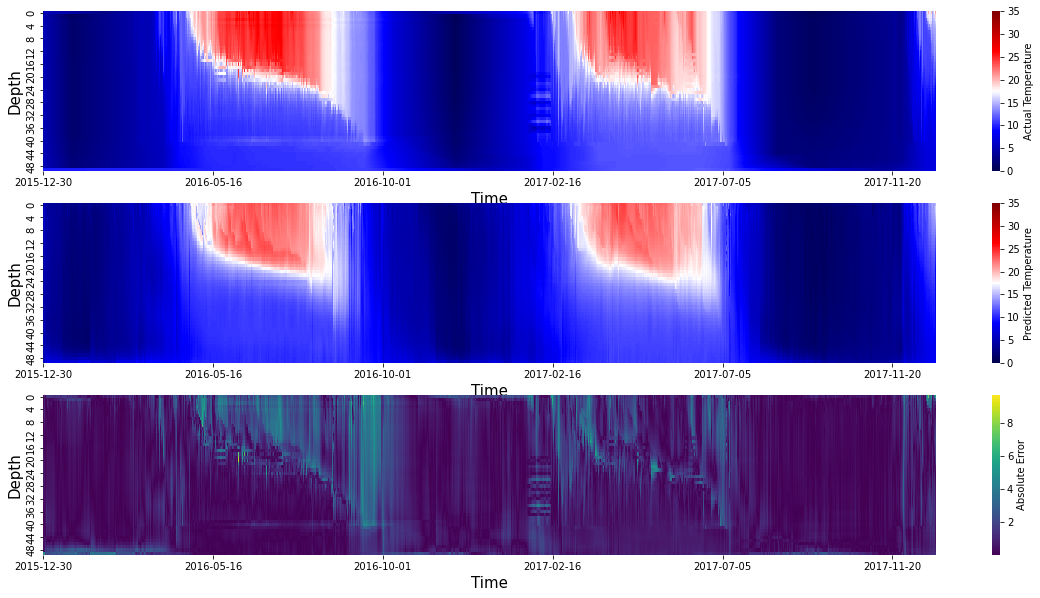

In [32]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [33]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 3.426281
RMSE of after m0 3.4105678
RMSE of after m0 3.5331576
RMSE of after m0 3.6540346
RMSE of after m0 3.9661562
RMSE of after m0 3.6106014
RMSE of after m0 3.712575
RMSE of after m0 3.744987
RMSE of after m0 3.770912
RMSE of after m0 3.8708694
RMSE of after m0 3.8219104
RMSE of after m0 3.8136537
RMSE of after m0 3.8008444
RMSE of after m0 3.7500503
RMSE of after m0 2.961926
RMSE of after m0 3.0405686
RMSE of after m0 3.082454
RMSE of after m0 3.0238485
RMSE of after m0 2.7335858
RMSE of after m0 2.7195218
RMSE of after m0 2.695373
RMSE of after m0 2.773429
RMSE of after m0 2.8374524
RMSE of after m0 2.7873492
RMSE of after m0 2.8252707
RMSE of after m0 2.9868069
RMSE of after m0 3.7436817
RMSE of after m0 3.7907658
RMSE of after m0 3.840059
RMSE of after m0 3.7391107
RMSE of after m0 3.5806253
RMSE of after m0 3.4566214
RMSE of after m0 3.4754379
RMSE of after m0 3.7528522
RMSE of after m0 3.868331
RMSE of after m0 3.7143054
RMSE of after m0 3.513757
RMSE of afte

RMSE of after m0 1.2612013
RMSE of after m0 1.1659281
RMSE of after m0 1.0299109
RMSE of after m0 1.2957414
RMSE of after m0 1.324542
RMSE of after m0 1.3155441
RMSE of after m0 1.4645162
RMSE of after m0 1.2862512
RMSE of after m0 1.2804832
RMSE of after m0 1.3558506
RMSE of after m0 1.2549659
RMSE of after m0 1.2581165
RMSE of after m0 1.3799388
RMSE of after m0 1.5211093
RMSE of after m0 1.6912123
RMSE of after m0 1.7018031
RMSE of after m0 1.7894261
RMSE of after m0 1.7737484
RMSE of after m0 1.7721457
RMSE of after m0 1.7541972
RMSE of after m0 1.7983329
RMSE of after m0 1.546465
RMSE of after m0 1.5133739
RMSE of after m0 1.732621
RMSE of after m0 1.8391961
RMSE of after m0 1.9087683
RMSE of after m0 2.010235
RMSE of after m0 2.1934645
RMSE of after m0 2.3909874
RMSE of after m0 2.1875367
RMSE of after m0 2.0412416
RMSE of after m0 1.8877101
RMSE of after m0 2.0849195
RMSE of after m0 2.1771224
RMSE of after m0 2.253532
RMSE of after m0 2.4475212
RMSE of after m0 2.48508
RMSE of 

RMSE of after m0 5.7383966
RMSE of after m0 5.179921
RMSE of after m0 5.062851
RMSE of after m0 5.054774
RMSE of after m0 5.2237577
RMSE of after m0 5.4516153
RMSE of after m0 5.363924
RMSE of after m0 5.2555137
RMSE of after m0 5.050303
RMSE of after m0 4.814601
RMSE of after m0 4.6192756
RMSE of after m0 4.164217
RMSE of after m0 4.0689692
RMSE of after m0 4.0131845
RMSE of after m0 3.9068608
RMSE of after m0 3.8084235
RMSE of after m0 4.1335773
RMSE of after m0 4.6056566
RMSE of after m0 4.6006284
RMSE of after m0 4.744531
RMSE of after m0 4.159627
RMSE of after m0 3.8886373
RMSE of after m0 4.0441985
RMSE of after m0 3.8854384
RMSE of after m0 3.732803
RMSE of after m0 3.6574726
RMSE of after m0 3.678648
RMSE of after m0 3.6466813
RMSE of after m0 3.6803877
RMSE of after m0 3.2899785
RMSE of after m0 3.0686433
RMSE of after m0 3.2141201
RMSE of after m0 3.4376786
RMSE of after m0 3.502444
RMSE of after m0 3.612781
RMSE of after m0 3.5951025
RMSE of after m0 3.3737056
RMSE of after 

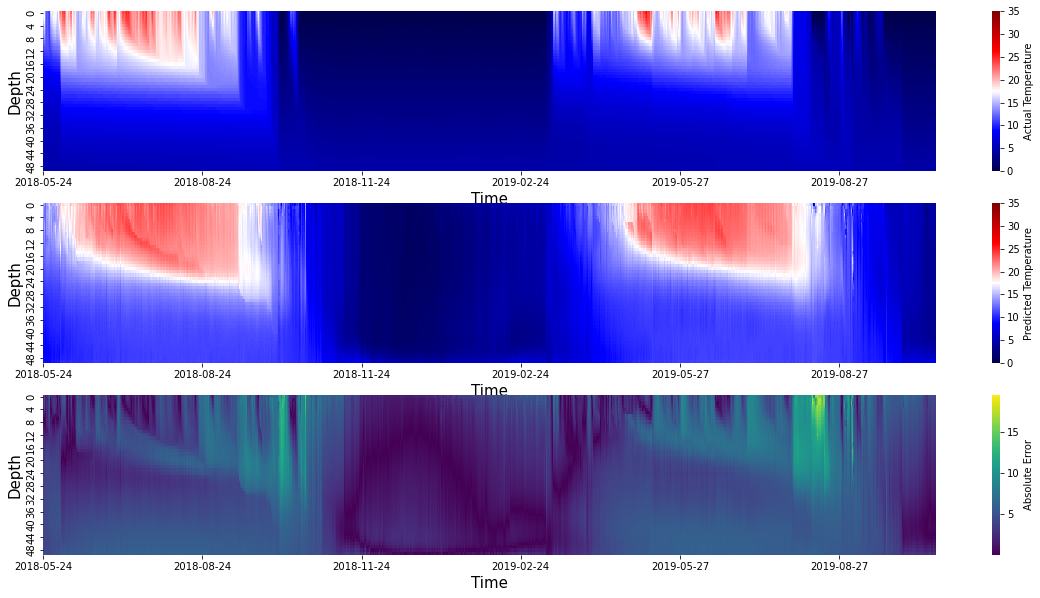

In [34]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

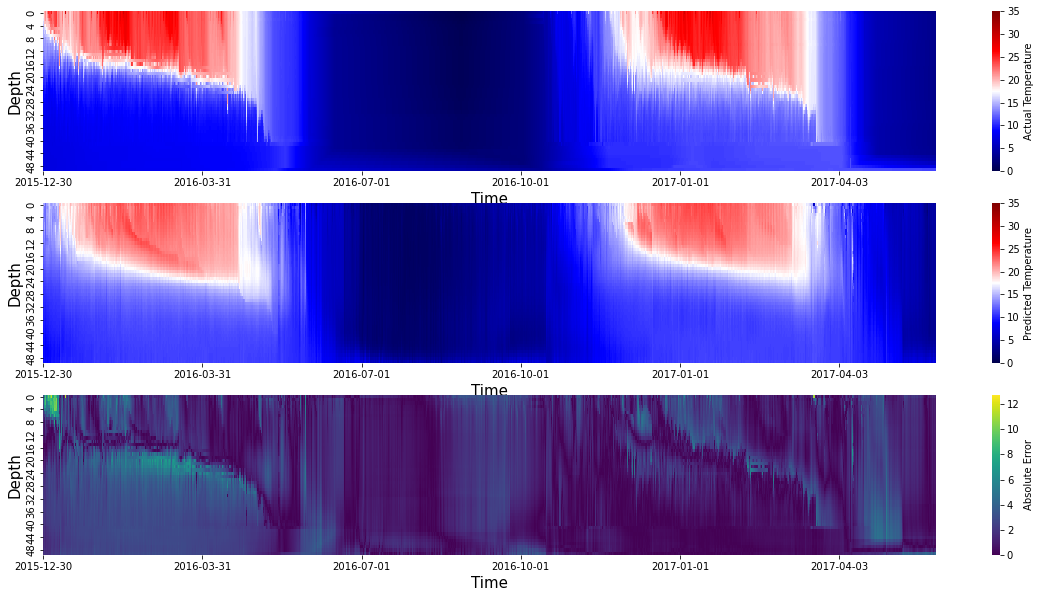

In [35]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [ ]:
#PATH = f"./saved_models/diffusion_model_finetuned.pth"
#torch.save(heat_diff_model.state_dict(), PATH)